In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'


2025-05-02 11:26:26.362597: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 11:26:26.388596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746206786.409078   66228 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746206786.411599   66228 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 11:26:26.444978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='08:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39105 instead
  warnings.warn(
/glade/work/linnia/conda-envs/mlenv/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.01s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


In [12]:
client

<Client: 'tcp://128.117.208.174:40155' processes=12 threads=12, memory=223.56 GiB>

### setup

In [4]:
def get_biome_param_names(b, u_params, pft_params):
    
    with open(utils_path+"/biome_configs.pkl", "rb") as f:
        biome_configs = pickle.load(f)

    param_names = list(u_params)
    for pft in biome_configs[b]['pfts']:
        pft_param_names = [f"{param}_{pft}" for param in pft_params]
        param_names.extend(pft_param_names)

    return param_names

In [5]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get observations & set stdev so high the optimization ignores some biome/variable combinations
obs = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')
obs_biome = obs.copy()
obs_biome['biomassC_stdev'].loc[{'biome': 12}] = 100

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]

# Build universal_set tensor
universal_set = tf.constant(default_params[u_params].iloc[[0]].to_numpy(),dtype=tf.float64)

x_default = tf.constant(default_params.drop(columns=u_params).iloc[[0]].to_numpy(), dtype=tf.float64)


2025-05-02 11:27:00.838837: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai_compiled/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp_compiled/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass_compiled/'
}

biomes = [1,2,3,5,6,7,8,9,10,11,12,13] # excluding biome4
param_indices = []
targets = []
stdevs = []
emulators = []

for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b,u_params,pft_params)
    param_ix = [default_params.columns.get_loc(p)for p in param_names]
    
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    
    targets.extend([
        tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_mean.isel(biome=b).values, dtype=tf.float64)
    ])
    stdevs.extend([
        tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_stdev.isel(biome=b).values, dtype=tf.float64)
    ])

    emulators.extend([
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ])
    
targets = tf.stack(targets, axis=0)  
stdevs = tf.stack(stdevs, axis=0)   


In [7]:
# ——— for fast graph execution ———
lengths = [len(arr) for arr in param_indices]     # list of Python ints

emulator_array = []
for m,input_dim in zip(emulators, lengths):
    sig = tf.TensorSpec([None, input_dim], tf.float64)
    f = tf.function(lambda X, _m=m: _m.compiled_predict_f(X)[0], input_signature=[sig])
    emulator_array.append(f)

### Functions

In [8]:

@tf.function
def optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, earlystop_batchPtile=75.0, barrier_strength=0.0, lambda_penalty=0.0):
    with tf.GradientTape() as tape:
        batch = tf.shape(x)[0]
        u_tiled = tf.tile(universal_set, [batch, 1])   
        x_full = tf.concat([u_tiled, x], axis=1)
        per_model_losses = []
        
        # loop over metrics and biomes in stacked 1D arrays. 
        for i in range(len(emulator_array)):
            model   = emulator_array[i]

            target = tf.reshape(targets[i], (1, -1))
            stdev = tf.reshape(stdevs[i], (1, -1))
            target_tiled = tf.tile(target, [batch, 1])
            stdev_tiled = tf.tile(stdev, [batch, 1])
        
            ix  = param_indices[i]          
            x_biome = tf.gather(x_full, ix, axis=1)
            y_pred = model(x_biome)
            z = tf.abs((y_pred - target_tiled)/stdev_tiled)
            
            loss_i = tf.reshape(z, [-1])  # size [batch]
            per_model_losses.append(loss_i)
            
        loss_per_sample = tf.add_n([z**2 for z in per_model_losses])  # shape [batch]
        data_loss = tf.reduce_mean(loss_per_sample) # overall scalar loss = average over the batch size (1) 
        max_z = tfp.stats.percentile(loss_per_sample, earlystop_batchPtile, interpolation='midpoint')

        # Penalty for moving from default
        # sum over the parameter‐axis (axis=1) → shape [batch]
        x_default_tiled = tf.tile(x_default, [batch, 1])
        sum_abs = tf.reduce_sum(tf.abs(x - x_default_tiled), axis=1)
        penalty = tf.reduce_mean(sum_abs) # mean of batch
        if lambda_penalty > 0.0:
            ratio = penalty / lambda_penalty
            default_pen = tf.maximum(ratio, 1.0) # if the penalty ==lambda, it no longer impacts loss
        else:
            default_pen = 1.0
        total_loss = data_loss * default_pen

        # Penalty for being close to the bounds (0,1)
        barrier = tf.reduce_mean(1.0 / (x + 1e-6) + 1.0 / (1.0 - x + 1e-6))
        bound_pen= (1.0 + barrier_strength * barrier)
        total_loss = total_loss * bound_pen
        
    grads = tape.gradient(total_loss, [x])
    optimizer.apply_gradients(zip(grads, [x]))
    x.assign(tf.clip_by_value(x, 0.0, 1.0))
    return total_loss, max_z, data_loss, default_pen, bound_pen

In [9]:

def run_optimization(x, universal_set, emulator_array, param_indices, x_default, maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, earlystop_batchPtile, barrier_strength, lambda_penalty=0.0):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=lr_decay_steps,
        decay_rate=0.5,
        staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    history_total_loss = []
    history_max_loss = []
    history_data_loss = []
    history_penalty = []
    history_barrier = []
    
    for step in range(maxiter):

        total_loss, max_z, data_loss, penalty, barrier_loss = optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, earlystop_batchPtile, barrier_strength, lambda_penalty)

        # log
        history_total_loss.append(total_loss.numpy())
        history_max_loss.append(max_z.numpy())
        history_data_loss.append(data_loss.numpy())
        history_penalty.append(penalty.numpy())
        history_barrier.append(barrier_loss.numpy())

        # print updates to screen 
        if step % 10 == 0:
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
    
        # Save a checkpoint every N iterations
        if step % checkpoint_N == 0:
            checkpoint = {
                'step': step,
                'params': x,
                'loss': total_loss,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{step}.pkl')
            with open(checkpoint_path, 'wb') as f:
                pickle.dump(checkpoint, f)
                
        # early stopping
        if tf.reduce_max(max_z) <= epsilon:
            print(f"Converged at step {step}")
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
            break
    
    x_opt = x.numpy()
    logs = {
        'total_loss': history_total_loss,
        'max_z': history_max_loss,
        'data_loss': history_data_loss,
        'penalty': history_penalty,
        'barrier': history_barrier
    }
    
    return x_opt, logs

### calibration

In [10]:
x0=np.loadtxt('init_unif_random.csv',delimiter=',')
#x0 = x0.drop(columns=u_params)

x_init = tf.Variable(
    tf.constant(x0, dtype=tf.float64),
    trainable=True,
    name="x"
)

In [13]:
%%time
# Run optimization
epsilon = 0.5
earlystop_batchPtile = 75.0
lr = 1e-2
maxiter=1000
lr_decay_steps = 300
checkpoint_N = 10
checkpoint_dir = './checkpoints_PhilosophyB/'
lambda_penalty = 0
barrier_strength = 0 # 3 % of total loss

x_opt, logs = run_optimization(x_init, universal_set, emulator_array, param_indices, x_default, 
                               maxiter, lr, lr_decay_steps, checkpoint_N, checkpoint_dir, epsilon, earlystop_batchPtile, barrier_strength, lambda_penalty)

Step 000: total=952.943062 max_z=1227.092942
Step 010: total=349.232264 max_z=432.156582
Step 020: total=167.744291 max_z=190.765727
Step 030: total=102.790958 max_z=118.565116
Step 040: total=72.551737 max_z=84.631015
Step 050: total=56.191364 max_z=65.837083
Step 060: total=46.085587 max_z=54.287107
Step 070: total=39.181973 max_z=46.429558
Step 080: total=34.121266 max_z=40.719444
Step 090: total=30.223053 max_z=36.295887
Step 100: total=27.118877 max_z=32.715627
Step 110: total=24.581427 max_z=29.666194
Step 120: total=22.470329 max_z=27.185798
Step 130: total=20.676423 max_z=25.066766
Step 140: total=19.137637 max_z=23.156578
Step 150: total=17.805308 max_z=21.570907
Step 160: total=16.636465 max_z=20.188379
Step 170: total=15.604682 max_z=18.989021
Step 180: total=14.687380 max_z=17.917961
Step 190: total=13.867071 max_z=17.046679
Step 200: total=13.131127 max_z=16.225473
Step 210: total=12.465218 max_z=15.420264
Step 220: total=11.857596 max_z=14.665366
Step 230: total=11.304881

In [14]:
# =========================== save ======================================
n_inits = np.shape(x_opt)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x_opt],axis=1)
calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

outfile = checkpoint_dir + 'calibrated_sets_unifRandom_clipNoPenalties_minError_050225.csv'
calibrated_paramsets.to_csv(outfile,index=False)

### plot convergence logs

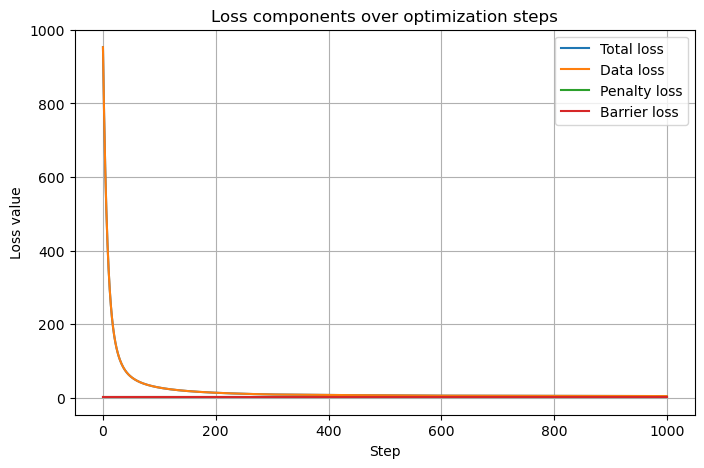

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(logs['total_loss'], label='Total loss')
plt.plot(logs['data_loss'], label='Data loss')
plt.plot(logs['penalty'], label='Penalty loss')
plt.plot(logs['barrier'], label='Barrier loss')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.legend()
plt.grid(True)
plt.title('Loss components over optimization steps')
#plt.ylim(0,5)
plt.savefig('loss_plot_unifRandom_minError_clipNoPenalties.png')


### Plot posteriors

In [ ]:
n_inits = np.shape(x_opt)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x_opt],axis=1)
full_calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)


In [ ]:
full_calibrated_paramsets = pd.read_csv('calibrated_sets_unifRandom.csv')

In [ ]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.axvline(default_params[pft_param_names[i]].values)
            ax.set_xlim([0,1])
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=50,
                #cmap='Blues',
                vmin=0,
                vmax=20,
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            #ax.set_ylim([0,1])
            #ax.set_xlim([0,1])

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'_randUnif_cal.png', dpi = 300)